# MED-PC Extracting the Recording Data and Metadata

## Importing the Python Libraries

In [1]:
import sys
import glob
from collections import defaultdict
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from moviepy.editor import *
from datetime import datetime
from IPython.display import Video
from pathlib import Path
from datetime import datetime


In [2]:
from medpc2excel.medpc_read import medpc_read
import cv2
import h5py
import numpy as np
from functools import reduce
from scipy.interpolate import interp1d
import ast

# Getting Tone Times

In [3]:
tone_start_df = pd.read_excel("./data/reward_comp_tone_sleap_frames.xlsx")

- Getting the file name as opposed to the whole path

In [4]:
tone_start_df["File Name"] = tone_start_df["File Name"].apply(lambda x: x.split(".")[0])

In [5]:
tone_start_df["date"] = tone_start_df["File Name"].apply(lambda x: datetime.strptime(x.split("_")[0].strip(""), '%m-%d-%y').strftime('%Y-%m-%d'))



In [6]:
tone_start_df

,File Name,Frame Start,FPS,Strain,date
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,2022-10-03
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,2022-10-03
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2022-10-03
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2022-10-03
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2022-10-03
5,10-03-22_Test_15_1-2v1-4,2126,29,C57,2022-10-03
6,10-03-22_Test_16_1-1v1-3,2139,30,C57,2022-10-03
7,10-03-22_Test_19_3-2v3-4,2090,30,C57,2022-10-03
8,10-03-22_Test_20_3-1v3-3,2100,30,C57,2022-10-03
9,10-04-22_Test_7_3-1v3-4,1838,30,C57,2022-10-04


- Getting the subject name from the file name

In [7]:
tone_start_df["subj_1"] = tone_start_df["File Name"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v"))[0].replace("-", ".").strip())

In [8]:
tone_start_df["subj_2"] = tone_start_df["File Name"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v"))[1].replace("-", ".").strip())

- Creating a tuple of the subject names so we can cross reference data sets

In [9]:
tone_start_df["all_subj"] = tone_start_df.apply(lambda x: tuple(sorted([str(x["subj_1"]), str(x["subj_2"])])) , axis=1)

In [10]:
tone_start_df

,File Name,Frame Start,FPS,Strain,date,subj_1,subj_2,all_subj
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,2022-10-03,1.1,1.2,"(1.1, 1.2)"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,2022-10-03,1.3,1.4,"(1.3, 1.4)"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2022-10-03,2.1,2.2,"(2.1, 2.2)"
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2022-10-03,2.2,2.4,"(2.2, 2.4)"
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2022-10-03,2.1,2.3,"(2.1, 2.3)"
5,10-03-22_Test_15_1-2v1-4,2126,29,C57,2022-10-03,1.2,1.4,"(1.2, 1.4)"
6,10-03-22_Test_16_1-1v1-3,2139,30,C57,2022-10-03,1.1,1.3,"(1.1, 1.3)"
7,10-03-22_Test_19_3-2v3-4,2090,30,C57,2022-10-03,3.2,3.4,"(3.2, 3.4)"
8,10-03-22_Test_20_3-1v3-3,2100,30,C57,2022-10-03,3.1,3.3,"(3.1, 3.3)"
9,10-04-22_Test_7_3-1v3-4,1838,30,C57,2022-10-04,3.1,3.4,"(3.1, 3.4)"


In [11]:
tone_start_df = tone_start_df[tone_start_df["Frame Start"].astype(str).str.isnumeric()]

In [12]:
# ITIs from MED-PC code
all_itis = [80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]

In [13]:
# Converting the seconds into frames
all_itis = [num * 30 for num in all_itis]

- Function that let's you cumuatively add a list of items

In [14]:
def get_running_total(lst):
    """
    """
    return reduce(lambda acc, x: acc + [acc[-1] + x] if acc else [x], lst, [])

In [15]:
tone_start_df["all_tone_frame"] = tone_start_df.apply(lambda row: get_running_total([row["Frame Start"]] + all_itis), axis=1)

In [16]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,date,subj_1,subj_2,all_subj,all_tone_frame
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,2022-10-03,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,2022-10-03,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2022-10-03,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ..."
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2022-10-03,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ..."
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2022-10-03,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ..."


# Get Coordinates of all the corners

- Reading in all the files with the corner coordinate and the pose tracking"

In [17]:
all_corner_h5 = glob.glob("/scratch/back_up/dominance_strain_comparison/proc/distance_calculation/corner_labeling/*/*/*.corner.h5")

In [18]:
all_pose_estimation_h5 = glob.glob("/scratch/back_up/dominance_strain_comparison/proc/distance_calculation/h5/*/*/*.h5")

In [19]:
len(all_corner_h5)

33

In [20]:
len(all_pose_estimation_h5)

33

- Matching all the video file names to the corresponding corner and pose tracking coordinate file

In [21]:
file_name_to_corner = {item.split("/")[-1].split(".")[0].strip(): item for item in all_corner_h5}

In [22]:
file_name_to_pose_estimation = {item.split("/")[-1].split(".")[0].strip(): item for item in all_pose_estimation_h5}

In [23]:
tone_start_df["corner_file"] = tone_start_df["File Name"].map(file_name_to_corner)
tone_start_df["pose_estimation_file"] = tone_start_df["File Name"].map(file_name_to_pose_estimation)

In [24]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,date,subj_1,subj_2,all_subj,all_tone_frame,corner_file,pose_estimation_file
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,2022-10-03,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,2022-10-03,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2022-10-03,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2022-10-03,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2022-10-03,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...


- Function that gets the SLEAP data

In [25]:
def get_sleap_coordinates(filename):
    """
    """
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        track_names = [n.decode() for n in f["track_names"][:]]
    return locations, node_names, track_names

In [26]:
corner_node_names = get_sleap_coordinates(all_corner_h5[0])[1]

In [27]:
corner_node_names

['box_bottom_left',
 'reward_port',
 'box_bottom_right',
 'box_top_left',
 'box_top_right']

- Getting the coordinates of each corner and the reward port

In [28]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["corner_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [29]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,date,subj_1,subj_2,all_subj,all_tone_frame,corner_file,pose_estimation_file,box_bottom_left_coordinates,reward_port_coordinates,box_bottom_right_coordinates,box_top_left_coordinates,box_top_right_coordinates
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,2022-10-03,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,2022-10-03,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2022-10-03,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[336.35679625338616, 588.6368242233518]","[508.9149672788628, 621.5982963374584]","[680.1398630208826, 585.5933059960898]","[343.6821422185993, 166.10302351623739]","[675.7125022249096, 169.20404824713103]"
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2022-10-03,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[389.47144456886895, 548.2629792077062]","[512.0763306227065, 569.902165576138]","[637.5798522460396, 557.7260413970237]","[409.4781326203461, 254.70146395943902]","[643.5017427415908, 262.46446072195494]"
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2022-10-03,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ...",/scratch/back_up/dominance_strain_comparison/p...,/scratch/back_up/dominance_strain_comparison/p...,"[348.83436667302124, 625.1914641653954]","[521.0751140419263, 658.3645972713236]","[692.7881935097188, 628.0072119332935]","[350.74679246264736, 214.02687569988802]","[695.0034616441534, 206.79059001184606]"


In [30]:
corner_columns = [col for col in tone_start_df.columns if "coordinates" in col]

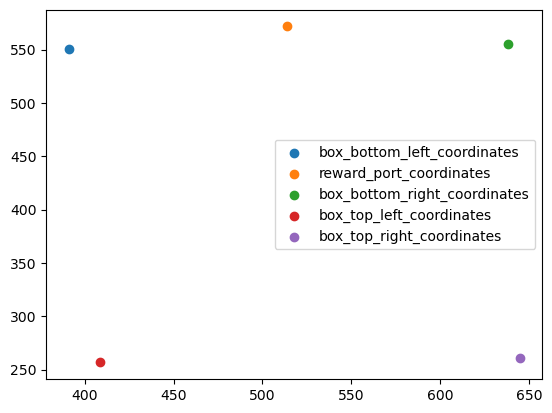

In [31]:
fig, ax = plt.subplots()

for index, row in tone_start_df.iterrows():
    for corner in corner_columns:
        plt.scatter(row[corner][0], row[corner][1], label=corner)
    break
plt.legend()

# Getting the distances between corners

- Getting the average width and height so that we can convert pixels to cm

In [32]:
tone_start_df["bottom_width"] = tone_start_df.apply(lambda row: row["box_bottom_right_coordinates"][0] - row["box_bottom_left_coordinates"][0], axis=1)
tone_start_df["top_width"] = tone_start_df.apply(lambda row: row["box_top_right_coordinates"][0] - row["box_top_left_coordinates"][0], axis=1)

In [33]:
tone_start_df["right_height"] = tone_start_df.apply(lambda row: row["box_bottom_right_coordinates"][1] - row["box_top_right_coordinates"][1], axis=1)
tone_start_df["left_height"] = tone_start_df.apply(lambda row: row["box_bottom_left_coordinates"][1] - row["box_top_left_coordinates"][1], axis=1)

In [34]:
tone_start_df["average_height"] = tone_start_df.apply(lambda row: (row["right_height"] + row["left_height"])/2, axis=1)
tone_start_df["average_width"] = tone_start_df.apply(lambda row: (row["bottom_width"] + row["top_width"])/2, axis=1)

- Getthing the pixel to cm ratio

In [35]:
tone_start_df["width_ratio"] = 29.5 / tone_start_df["average_width"]
tone_start_df["height_ratio"] = 24 / tone_start_df["average_height"]


In [36]:
tone_start_df["reward_port_scaled"] = tone_start_df.apply(lambda row: np.array([row["reward_port_coordinates"][0] * row["width_ratio"], row["reward_port_coordinates"][1] * row["height_ratio"]]), axis=1)

In [37]:
tone_start_df["reward_port_scaled"]

0        [62.65767561559346, 46.6450642268789]
1      [44.79031206327622, 38.095121316373195]
2       [44.42939704940567, 35.56550022490564]
3      [62.66437903191042, 46.457593353668756]
4       [44.67155311688311, 37.96517782319081]
5       [43.48033926710607, 35.45305995884919]
6       [63.67403573088538, 47.18483629837384]
7      [43.50130361232485, 35.355649768653635]
8      [63.61830704527882, 47.078440172566104]
9       [64.53216327469285, 47.11044009374468]
10       [63.43516068508019, 47.6202483305839]
11       [62.85596760361868, 46.5217960004979]
12      [44.98362245572794, 37.64878595279556]
13      [65.42517992066077, 46.61455513415089]
14     [63.046091498234816, 46.91265128411644]
15      [63.55260453352851, 46.89055487864883]
17    [63.627820961484495, 45.886329355603685]
18     [43.099918367994746, 35.61912482253337]
19       [64.1506118178146, 47.81908162396559]
20    [44.148772051313195, 35.101527543757406]
21      [65.32806162465717, 47.14667016127896]
22      [44.6

# Getting the coordinates of each mouse

- Function that fills missing coordinates by interpolating

In [38]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y


In [39]:
body_part_node_names = get_sleap_coordinates(all_pose_estimation_h5[0])[1]

In [40]:
body_part_node_names

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

- Function that scales each coordinate

In [41]:
def scale_coordinates(row, coordinate_col, height_ratio_col="height_ratio", width_ratio_col="width_ratio"):
    """
    """
    return np.dstack((row[coordinate_col][:,:,0] * row[width_ratio_col], row[coordinate_col][:,:,1] * row[height_ratio_col]))


In [42]:
for num in range(2):
    tone_start_df["pose_estimation_subj_{}_original_coordinates".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: fill_missing(get_sleap_coordinates(x)[0][:,:,:,num]))
    tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)] = tone_start_df.apply(lambda row: scale_coordinates(row, "pose_estimation_subj_{}_original_coordinates".format(num + 1)), axis=1)     
    tone_start_df["pose_estimation_subj_{}_thorax_coordinates".format(num + 1)] = tone_start_df["pose_estimation_subj_{}_scaled_coordinates".format(num + 1)].apply(lambda x: x[:,4,:])
    tone_start_df["pose_estimation_subj_{}_name".format(num + 1)] = tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[2][num])


In [43]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,date,subj_1,subj_2,all_subj,all_tone_frame,corner_file,...,height_ratio,reward_port_scaled,pose_estimation_subj_1_original_coordinates,pose_estimation_subj_1_scaled_coordinates,pose_estimation_subj_1_thorax_coordinates,pose_estimation_subj_1_name,pose_estimation_subj_2_original_coordinates,pose_estimation_subj_2_scaled_coordinates,pose_estimation_subj_2_thorax_coordinates,pose_estimation_subj_2_name
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,2022-10-03,1.1,1.2,"(1.1, 1.2)","[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",/scratch/back_up/dominance_strain_comparison/p...,...,0.081602,"[62.65767561559346, 46.6450642268789]","[[[520.4361572265625, 564.3905639648438], [499...","[[[63.45613955133118, 46.055351719549506], [60...","[[64.2990287199225, 44.027829978141874], [64.2...",1.1,"[[[368.9432067871094, 284.2481384277344], [392...","[[[44.98479072084644, 23.195192880177135], [47...","[[47.306155506552955, 24.141277551998048], [47...",1.2
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,2022-10-03,1.3,1.4,"(1.3, 1.4)","[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",/scratch/back_up/dominance_strain_comparison/p...,...,0.057763,"[44.79031206327622, 38.095121316373195]","[[[680.289306640625, 400.05560302734375], [676...","[[[58.644644060289274, 23.108399542698006], [5...","[[61.7094413419158, 22.198077497602327], [61.7...",1.3,"[[[531.3592529296875, 648.0527954101562], [499...","[[[45.80606214447569, 37.43345376936677], [43....","[[46.209723992701065, 34.683338490517976], [46...",1.4
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2022-10-03,2.1,2.2,"(2.1, 2.2)","[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",/scratch/back_up/dominance_strain_comparison/p...,...,0.057216,"[44.42939704940567, 35.56550022490564]","[[[315.74310302734375, 508.35687255859375], [3...","[[[27.565068021130507, 29.086254855981128], [2...","[[30.34017396475596, 30.427972245799346], [30....",2.1,"[[[520.195556640625, 616.1532592773438], [499....","[[[45.41421733556245, 35.25395582729842], [43....","[[47.534636695053486, 32.74008833373921], [47....",2.2
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,2022-10-03,2.2,2.4,"(2.2, 2.4)","[2138, 4538, 7238, 9638, 11888, 14888, 17738, ...",/scratch/back_up/dominance_strain_comparison/p...,...,0.081519,"[62.66437903191042, 46.457593353668756]","[[[563.5345458984375, 584.265380859375], [552....","[[[68.96148146275858, 47.628461715267704], [67...","[[71.41175226058016, 45.614624361532364], [71....",2.2,"[[[383.81134033203125, 507.93603515625], [387....","[[[46.96819178903383, 41.40620477746066], [47....","[[50.947502939058204, 41.122758181192154], [50...",2.4
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,2022-10-03,2.1,2.3,"(2.1, 2.3)","[2127, 4527, 7227, 9627, 11877, 14877, 17727, ...",/scratch/back_up/dominance_strain_comparison/p...,...,0.057666,"[44.67155311688311, 37.96517782319081]","[[[352.04791259765625, 239.75645446777344], [3...","[[[30.180921336474817, 13.825768374929051], [3...","[[35.329769344397896, 13.176087411670519], [35...",2.1,"[[[440.73870849609375, 235.83706665039062], [4...","[[[37.784346434294605, 13.599753403799516], [3...","[[36.037506728469545, 14.767165547980444], [36...",2.3


In [44]:
tone_start_df["pose_estimation_subj_1_thorax_coordinates"].iloc[0].shape

(55952, 2)

# Calculating the distance from thorax to reward port

In [45]:
tone_start_df["thorax_to_reward_port_distance_subj_1"] = tone_start_df.apply(lambda row: np.linalg.norm(row["pose_estimation_subj_1_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)
tone_start_df["thorax_to_reward_port_distance_subj_2"] = tone_start_df.apply(lambda row: np.linalg.norm(row["pose_estimation_subj_2_thorax_coordinates"] - row["reward_port_scaled"], axis=1), axis=1)



In [46]:
frame_range = 20 * 30

In [47]:
tone_start_df["thorax_to_reward_port_tone_slices_subj_1"] = tone_start_df.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance_subj_1"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance_subj_1"].shape[0]]), axis=1)
tone_start_df["thorax_to_reward_port_tone_slices_subj_2"] = tone_start_df.apply(lambda row:  np.vstack([row["thorax_to_reward_port_distance_subj_2"][tone_frame-frame_range:tone_frame+frame_range] for tone_frame in row["all_tone_frame"] if tone_frame <= row["thorax_to_reward_port_distance_subj_2"].shape[0]]), axis=1)


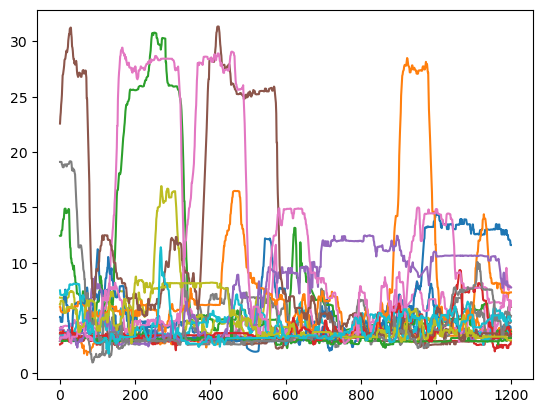

In [48]:
# Iterate over each row in the array
for i, row in enumerate(tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[0]):
    # Plot the row data
    plt.plot(row, label=f'Line {i+1}')



# Averaging across trials

In [49]:
tone_start_df["thorax_to_reward_port_tone_trial_average_subj_1"] = tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].apply(lambda x: np.mean(x, axis=0))
tone_start_df["thorax_to_reward_port_tone_trial_average_subj_2"] = tone_start_df["thorax_to_reward_port_tone_slices_subj_2"].apply(lambda x: np.mean(x, axis=0))

In [50]:
c57_mean_distance = np.mean(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"], axis=0)
cd1_mean_distance = np.mean(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"], axis=0)
cd1_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0) / np.sqrt(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape[0])  
c57_sem_distance = np.std(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].to_list(), axis=0) / np.sqrt(tone_start_df[tone_start_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape[0])  

In [51]:
tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].iloc[0].shape

(1200,)

In [52]:
np.sqrt(tone_start_df[tone_start_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj_1"].shape[0])  

4.0

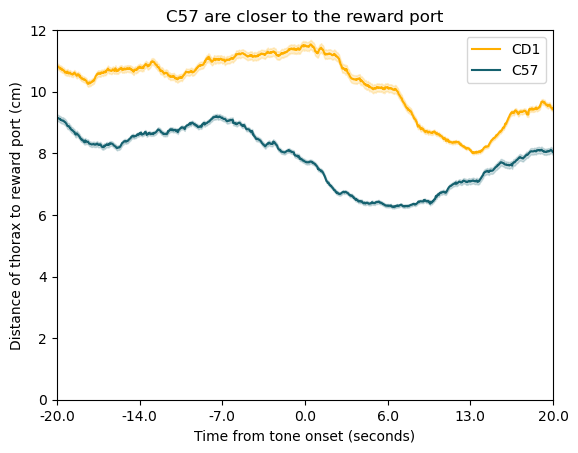

In [53]:
# Add shading for the standard error
plt.plot(cd1_mean_distance, color="#ffaf00", label="CD1")
plt.fill_between(range(len(cd1_mean_distance)), cd1_mean_distance - cd1_sem_distance, cd1_mean_distance + cd1_sem_distance, color="#ffaf00", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_mean_distance, color="#15616f", label="C57")
plt.fill_between(range(len(c57_mean_distance)), c57_mean_distance - c57_sem_distance, c57_mean_distance + c57_sem_distance, color="#15616f", alpha=0.2)
plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("C57 are closer to the reward port")

plt.legend()

# Separating Rows into the two subjects

In [54]:
tone_start_df.columns

Index(['File Name', 'Frame Start', 'FPS', 'Strain', 'date', 'subj_1', 'subj_2',
       'all_subj', 'all_tone_frame', 'corner_file', 'pose_estimation_file',
       'box_bottom_left_coordinates', 'reward_port_coordinates',
       'box_bottom_right_coordinates', 'box_top_left_coordinates',
       'box_top_right_coordinates', 'bottom_width', 'top_width',
       'right_height', 'left_height', 'average_height', 'average_width',
       'width_ratio', 'height_ratio', 'reward_port_scaled',
       'pose_estimation_subj_1_original_coordinates',
       'pose_estimation_subj_1_scaled_coordinates',
       'pose_estimation_subj_1_thorax_coordinates',
       'pose_estimation_subj_1_name',
       'pose_estimation_subj_2_original_coordinates',
       'pose_estimation_subj_2_scaled_coordinates',
       'pose_estimation_subj_2_thorax_coordinates',
       'pose_estimation_subj_2_name', 'thorax_to_reward_port_distance_subj_1',
       'thorax_to_reward_port_distance_subj_2',
       'thorax_to_reward_port_ton

- Getting all the columns with subject 1 or subject 2 in the name

In [55]:
subj_1_col = [col for col in tone_start_df.columns if "subj_1" in col or "Strain" in col or "all_subj" in col or "date" in col]
subj_2_col = [col for col in tone_start_df.columns if "subj_2" in col or "Strain" in col or "all_subj" in col or "date" in col]


In [56]:
subj_1_df = tone_start_df[subj_1_col].copy()
subj_2_df = tone_start_df[subj_2_col].copy()

- Standarizing all the columns so it's just "subj"

In [57]:
subj_1_df.columns = [col.replace("subj_1", "subj") for col in subj_1_df.columns]
subj_2_df.columns = [col.replace("subj_2", "subj") for col in subj_2_df.columns]

In [58]:
subj_1_df.head()

,Strain,date,subj,all_subj,pose_estimation_subj_original_coordinates,pose_estimation_subj_scaled_coordinates,pose_estimation_subj_thorax_coordinates,pose_estimation_subj_name,thorax_to_reward_port_distance_subj,thorax_to_reward_port_tone_slices_subj,thorax_to_reward_port_tone_trial_average_subj
0,C57,2022-10-03,1.1,"(1.1, 1.2)","[[[520.4361572265625, 564.3905639648438], [499...","[[[63.45613955133118, 46.055351719549506], [60...","[[64.2990287199225, 44.027829978141874], [64.2...",1.1,"[3.089329235587016, 3.089329235587016, 3.08932...","[[2.9228068043381485, 2.9940084997567036, 2.99...","[6.270681130895481, 6.3139301865404995, 6.3439..."
1,C57,2022-10-03,1.3,"(1.3, 1.4)","[[[680.289306640625, 400.05560302734375], [676...","[[[58.644644060289274, 23.108399542698006], [5...","[[61.7094413419158, 22.198077497602327], [61.7...",1.3,"[23.21579069778241, 23.21579069778241, 23.2157...","[[4.385010419901161, 4.562296860868675, 4.6032...","[7.092765392288027, 7.10707460786074, 7.081793..."
2,C57,2022-10-03,2.1,"(2.1, 2.2)","[[[315.74310302734375, 508.35687255859375], [3...","[[[27.565068021130507, 29.086254855981128], [2...","[[30.34017396475596, 30.427972245799346], [30....",2.1,"[14.996679661349255, 14.996679661349255, 14.99...","[[3.8624274453667535, 3.6958359445454856, 3.69...","[8.813829857006029, 8.829495476293536, 8.80688..."
3,C57,2022-10-03,2.2,"(2.2, 2.4)","[[[563.5345458984375, 584.265380859375], [552....","[[[68.96148146275858, 47.628461715267704], [67...","[[71.41175226058016, 45.614624361532364], [71....",2.2,"[8.787897081973108, 8.787897081973108, 8.78789...","[[5.590800622412532, 4.681775355696303, 4.6532...","[8.7653197705422, 8.794929284357522, 8.8011723..."
4,C57,2022-10-03,2.1,"(2.1, 2.3)","[[[352.04791259765625, 239.75645446777344], [3...","[[[30.180921336474817, 13.825768374929051], [3...","[[35.329769344397896, 13.176087411670519], [35...",2.1,"[26.490902730605374, 26.490902730605374, 26.49...","[[4.804053609351869, 4.805124933967146, 4.8111...","[8.261533583697924, 8.335039181133963, 8.38373..."


- Putting the dataframes for subject 1 and subject 2 together

In [59]:
combined_subj_df = pd.concat([subj_1_df, subj_2_df])

In [60]:
combined_subj_df["agent"] = combined_subj_df.apply(lambda x: list(set(x["all_subj"]) - set([x["subj"]]))[0], axis=1)

In [61]:
combined_subj_df.head()

,Strain,date,subj,all_subj,pose_estimation_subj_original_coordinates,pose_estimation_subj_scaled_coordinates,pose_estimation_subj_thorax_coordinates,pose_estimation_subj_name,thorax_to_reward_port_distance_subj,thorax_to_reward_port_tone_slices_subj,thorax_to_reward_port_tone_trial_average_subj,agent
0,C57,2022-10-03,1.1,"(1.1, 1.2)","[[[520.4361572265625, 564.3905639648438], [499...","[[[63.45613955133118, 46.055351719549506], [60...","[[64.2990287199225, 44.027829978141874], [64.2...",1.1,"[3.089329235587016, 3.089329235587016, 3.08932...","[[2.9228068043381485, 2.9940084997567036, 2.99...","[6.270681130895481, 6.3139301865404995, 6.3439...",1.2
1,C57,2022-10-03,1.3,"(1.3, 1.4)","[[[680.289306640625, 400.05560302734375], [676...","[[[58.644644060289274, 23.108399542698006], [5...","[[61.7094413419158, 22.198077497602327], [61.7...",1.3,"[23.21579069778241, 23.21579069778241, 23.2157...","[[4.385010419901161, 4.562296860868675, 4.6032...","[7.092765392288027, 7.10707460786074, 7.081793...",1.4
2,C57,2022-10-03,2.1,"(2.1, 2.2)","[[[315.74310302734375, 508.35687255859375], [3...","[[[27.565068021130507, 29.086254855981128], [2...","[[30.34017396475596, 30.427972245799346], [30....",2.1,"[14.996679661349255, 14.996679661349255, 14.99...","[[3.8624274453667535, 3.6958359445454856, 3.69...","[8.813829857006029, 8.829495476293536, 8.80688...",2.2
3,C57,2022-10-03,2.2,"(2.2, 2.4)","[[[563.5345458984375, 584.265380859375], [552....","[[[68.96148146275858, 47.628461715267704], [67...","[[71.41175226058016, 45.614624361532364], [71....",2.2,"[8.787897081973108, 8.787897081973108, 8.78789...","[[5.590800622412532, 4.681775355696303, 4.6532...","[8.7653197705422, 8.794929284357522, 8.8011723...",2.4
4,C57,2022-10-03,2.1,"(2.1, 2.3)","[[[352.04791259765625, 239.75645446777344], [3...","[[[30.180921336474817, 13.825768374929051], [3...","[[35.329769344397896, 13.176087411670519], [35...",2.1,"[26.490902730605374, 26.490902730605374, 26.49...","[[4.804053609351869, 4.805124933967146, 4.8111...","[8.261533583697924, 8.335039181133963, 8.38373...",2.3


In [62]:
combined_subj_df.tail()

,Strain,date,subj,all_subj,pose_estimation_subj_original_coordinates,pose_estimation_subj_scaled_coordinates,pose_estimation_subj_thorax_coordinates,pose_estimation_subj_name,thorax_to_reward_port_distance_subj,thorax_to_reward_port_tone_slices_subj,thorax_to_reward_port_tone_trial_average_subj,agent
30,CD1,2022-10-04,5.4,"(5.2, 5.4)","[[[88.17051696777344, 239.8760986328125], [327...","[[[7.798219478449879, 13.915672312545379], [29...","[[5.2637947403151495, 13.183080659645789], [5....",5.4,"[48.119976946542764, 48.119976946542764, 48.11...","[[4.397264808641687, 4.184783553083316, 4.1628...","[11.073973509636769, 11.250654282328513, 11.31...",5.2
31,CD1,2022-10-04,6.3,"(6.1, 6.3)","[[[627.939697265625, 484.0679016113281], [660....","[[[77.95524803119814, 39.4186548235274], [81.9...","[[79.42667534569996, 41.39959547456827], [79.4...",6.3,"[14.833755380668684, 14.833755380668684, 14.83...","[[4.78594882759814, 4.407607813767332, 4.40759...","[5.722839150196431, 5.684765262646173, 5.93168...",6.1
32,CD1,2022-10-04,6.4,"(6.2, 6.4)","[[[563.6663818359375, 275.8839111328125], [555...","[[[69.36750503537117, 22.616401322137502], [68...","[[63.50716614756996, 21.66278955425743], [63.5...",6.4,"[25.524667348618205, 25.524667348618205, 25.52...","[[29.711364511073473, 29.71038170786948, 29.70...","[7.321260477871428, 7.475858862153373, 7.54348...",6.2
33,CD1,2022-10-04,4.3,"(4.1, 4.3)","[[[611.711669921875, 548.6848754882812], [587....","[[[76.50036092990533, 46.0100792739556], [73.5...","[[77.02284160453519, 44.27597996897858], [77.0...",4.3,"[11.464414746554365, 11.464414746554365, 11.46...","[[3.7246798240214503, 3.7667584004042314, 3.96...","[7.238406130425346, 7.260504212472216, 7.23452...",4.1
34,CD1,2022-10-04,4.4,"(4.2, 4.4)","[[[379.53656005859375, 599.8545532226562], [36...","[[[47.826961882071544, 49.949656581318074], [4...","[[50.88618822100768, 46.60840236597737], [50.8...",4.2,"[13.99521367564662, 13.99521367564662, 13.9952...","[[22.4895368694164, 22.498382969555397, 22.498...","[12.074670768794935, 12.137827220271044, 12.22...",4.2


In [63]:
combined_subj_df.shape

(66, 12)

In [64]:
len(combined_subj_df["subj"].unique())

24

- Calculating the average distance

In [65]:
c57_mean_distance = np.mean(combined_subj_df[combined_subj_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_mean_distance = np.mean(combined_subj_df[combined_subj_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_sem_distance = np.std(combined_subj_df[combined_subj_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(combined_subj_df[combined_subj_df["Strain"] == "CD1"]["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  
c57_sem_distance = np.std(combined_subj_df[combined_subj_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(combined_subj_df[combined_subj_df["Strain"] == "C57"]["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  

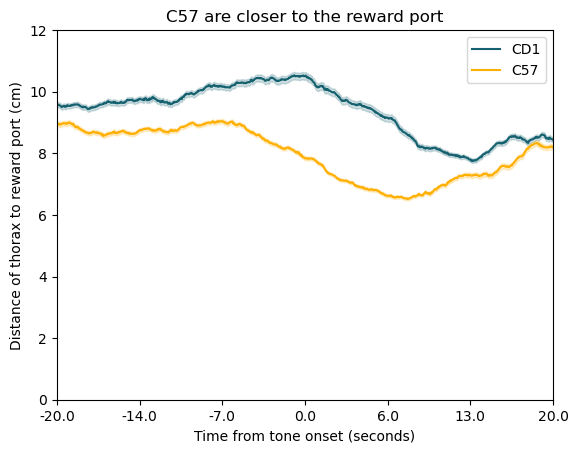

In [66]:
# Add shading for the standard error
plt.plot(cd1_mean_distance, color="#15616f", label="CD1")
plt.fill_between(range(len(cd1_mean_distance)), cd1_mean_distance - cd1_sem_distance, cd1_mean_distance + cd1_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_mean_distance, color="#ffaf00", label="C57")
plt.fill_between(range(len(c57_mean_distance)), c57_mean_distance - c57_sem_distance, c57_mean_distance + c57_sem_distance, color="#ffaf00", alpha=0.2)
plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)
plt.ylim(0, 12)
plt.title("C57 are closer to the reward port")

plt.legend()

# Adding the win and loss information

# Incorporating Winning and Losing

In [67]:
reward_comp_scoring_df = pd.read_csv("./data/scoring/pilot_3_reward_competition_all_competition_cage_1_2_3_4_5_6_date_20221003_20221004.csv")

In [68]:
reward_comp_scoring_df.columns

Index(['Unnamed: 0', 'rc_animal_ids', 'rc_date', 'rc_winner', 'rc_loser',
       'rc_winner_no_ties', 'rc_loser_no_ties',
       'rc_different_result_as_previous', 'rc_number_of_switches', 'cohort',
       'processed_cage_number', 'strain', 'rc_averaged_winner',
       'rc_averaged_loser', 'rc_winner_count', 'rc_loser_count',
       'rc_tie_count', 'rc_all_match_count_including_ties',
       'rc_winner_count_minus_loser_count', 'rc_win_to_win_plus_lost_ratio',
       'rc_win_to_all_ratio', 'rc_is_win_to_win_and_loss_ratio_tie',
       'rc_tie_to_all_ratio'],
      dtype='object')

- Updating the date so that we can merge using it

In [69]:
reward_comp_scoring_df["date"] = reward_comp_scoring_df["rc_date"].apply(lambda x: str(x).strip(""))

In [70]:
reward_comp_scoring_df["date"].iloc[0]

'2022-10-03'

- Updating the IDs so we can merge using it

In [71]:
reward_comp_scoring_df["all_subj"] = reward_comp_scoring_df["rc_animal_ids"].apply(lambda x: ast.literal_eval(x))

In [72]:
reward_comp_scoring_df["all_subj"].iloc[0]

('1.1', '1.2')

In [73]:
reward_comp_scoring_df["rc_winner"] = reward_comp_scoring_df["rc_winner"].apply(lambda x: ast.literal_eval(x))

In [74]:
reward_comp_scoring_df["rc_averaged_winner"] = reward_comp_scoring_df["rc_averaged_winner"].astype(str)
reward_comp_scoring_df["rc_averaged_loser"] = reward_comp_scoring_df["rc_averaged_loser"].astype(str)

In [75]:
for num in reward_comp_scoring_df["rc_winner"]:
    print(num)

['1.1', '1.2', '1.2', '1.1', 'tie', '1.1', '1.1', 'tie', '1.1', '1.2', 'tie', '1.2', '1.1', 'tie', '1.2', '1.2', '1.2', '1.2', '1.2']
['1.1', '1.1', '1.1', '1.1', '1.1', 'tie', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1']
['1.3', '1.3', '1.3', '1.3', '1.1', '1.1', 'tie', '1.1', '1.3', '1.1', 'tie', '1.1', 'tie', '1.3', '1.3', '1.3', '1.3', 'tie', 'tie']
['1.3', '1.3', 'tie', '1.3', '1.3', '1.3', '1.3', '1.1', 'tie', 'tie', '1.1', '1.3', '1.1', '1.1', '1.3', '1.1', '1.1', 'tie', '1.3']
['1.4', '1.4', '1.4', '1.4', '1.4', '1.4', '1.4', '1.1', '1.1', '1.4', '1.4', '1.1', '1.4', 'tie', '1.4', '1.1', '1.1', '1.4', '1.1']
['1.1', '1.1', 'tie', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', '1.1', 'tie', 'tie', '1.1', '1.4', '1.1', '1.1', '1.1', '1.4']
['1.3', '1.3', '1.2', 'tie', '1.2', '1.2', '1.3', '1.3', '1.3', 'tie', 'tie', '1.3', '1.3', '1.3', '1.3', '1.3', '1.3', '1.2', '1.2']
['1.3', '1.3', '1.3', '1.3', '1.3', '1.2', '1.2', '1.3', '1.3'

- Merging the dataframes

In [76]:
combined_subj_df["date"]

0     2022-10-03
1     2022-10-03
2     2022-10-03
3     2022-10-03
4     2022-10-03
         ...    
30    2022-10-04
31    2022-10-04
32    2022-10-04
33    2022-10-04
34    2022-10-04
Name: date, Length: 66, dtype: object

In [77]:
reward_comp_scoring_df["date"]

0     2022-10-03
1     2022-10-04
2     2022-10-03
3     2022-10-04
4     2022-10-03
         ...    
67    2022-10-04
68    2022-10-03
69    2022-10-04
70    2022-10-03
71    2022-10-04
Name: date, Length: 72, dtype: object

In [78]:
distance_and_scoring_df = combined_subj_df.merge(reward_comp_scoring_df, on=['date', 'all_subj'], how='outer')

In [79]:
distance_and_scoring_df = distance_and_scoring_df.dropna(subset=["rc_winner", "subj"])#.dropna(subset="subj")

- Getting all the winning and losing trials based on matching IDs

In [80]:
distance_and_scoring_df["subj"].unique()

array(['1.1', '1.2', '1.3', '1.4', '2.1', '2.2', '2.4', '2.3', '3.2',
       '3.4', '3.1', '3.3', '4.1', '4.2', '4.3', '4.4', '6.1', '6.2',
       '6.3', '6.4', '5.2', '5.4', '5.1', '5.3'], dtype=object)

In [81]:
distance_and_scoring_df["per_trial_winning_indexes"] = distance_and_scoring_df.apply(lambda x: [i for i, trial in enumerate(x["rc_winner"]) if trial == x["subj"] and i < x["thorax_to_reward_port_tone_slices_subj"].shape[0]], axis=1)
distance_and_scoring_df["per_trial_losing_indexes"] = distance_and_scoring_df.apply(lambda x: [i for i, trial in enumerate(x["rc_winner"]) if trial == x["agent"] and i < x["thorax_to_reward_port_tone_slices_subj"].shape[0]], axis=1)


In [82]:
distance_and_scoring_df["per_trial_winning_indexes"].head()

0                             [0, 3, 5, 6, 8, 12]
1               [1, 2, 9, 11, 14, 15, 16, 17, 18]
2                     [0, 2, 5, 7, 9, 12, 15, 16]
3                    [1, 3, 4, 6, 10, 11, 14, 17]
4    [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 16, 17]
Name: per_trial_winning_indexes, dtype: object

In [83]:
distance_and_scoring_df["per_trial_losing_indexes"].head()

0    [1, 2, 9, 11, 14, 15, 16, 17, 18]
1                  [0, 3, 5, 6, 8, 12]
2         [1, 3, 4, 6, 10, 11, 14, 17]
3          [0, 2, 5, 7, 9, 12, 15, 16]
4                  [0, 12, 13, 15, 18]
Name: per_trial_losing_indexes, dtype: object

In [84]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"] = distance_and_scoring_df.apply(lambda x: x["thorax_to_reward_port_tone_slices_subj"][x["per_trial_winning_indexes"]], axis=1)
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"] = distance_and_scoring_df.apply(lambda x: x["thorax_to_reward_port_tone_slices_subj"][x["per_trial_losing_indexes"]], axis=1)


In [85]:
distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].iloc[0].shape

(6, 1200)

In [86]:
distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].iloc[0].shape

(9, 1200)

- Averaging across winning and losing trials

In [87]:
distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"] = distance_and_scoring_df["thorax_to_reward_port_all_winning_trial_distances"].apply(lambda x: np.mean(x, axis=0))
distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"] = distance_and_scoring_df["thorax_to_reward_port_all_losing_trial_distances"].apply(lambda x: np.mean(x, axis=0))

- Filtering out rows that have NANs in the average distance array

In [88]:
distance_and_scoring_df[~distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].apply(lambda x: np.isnan(x).any())]

,Strain,date,subj,all_subj,pose_estimation_subj_original_coordinates,pose_estimation_subj_scaled_coordinates,pose_estimation_subj_thorax_coordinates,pose_estimation_subj_name,thorax_to_reward_port_distance_subj,thorax_to_reward_port_tone_slices_subj,...,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio,per_trial_winning_indexes,per_trial_losing_indexes,thorax_to_reward_port_all_winning_trial_distances,thorax_to_reward_port_all_losing_trial_distances,thorax_to_reward_port_tone_winning_trial_average,thorax_to_reward_port_tone_losing_trial_average
0,C57,2022-10-03,1.1,"(1.1, 1.2)","[[[520.4361572265625, 564.3905639648438], [499...","[[[63.45613955133118, 46.055351719549506], [60...","[[64.2990287199225, 44.027829978141874], [64.2...",1.1,"[3.089329235587016, 3.089329235587016, 3.08932...","[[2.9228068043381485, 2.9940084997567036, 2.99...",...,0.600000,0.473684,False,0.210526,"[0, 3, 5, 6, 8, 12]","[1, 2, 9, 11, 14, 15, 16, 17, 18]","[[2.9228068043381485, 2.9940084997567036, 2.99...","[[3.6291303746758503, 3.6273592630888487, 3.64...","[3.7709168134356807, 3.782869680961616, 3.7961...","[8.787142658569103, 8.91602020261441, 8.994076..."
1,C57,2022-10-03,1.2,"(1.1, 1.2)","[[[368.9432067871094, 284.2481384277344], [392...","[[[44.98479072084644, 23.195192880177135], [47...","[[47.306155506552955, 24.141277551998048], [47...",1.2,"[27.241321266906642, 27.241321266906642, 27.24...","[[5.609393150740746, 5.625132296975509, 5.6027...",...,0.600000,0.473684,False,0.210526,"[1, 2, 9, 11, 14, 15, 16, 17, 18]","[0, 3, 5, 6, 8, 12]","[[5.436863518167377, 5.434698577001676, 5.4444...","[[5.609393150740746, 5.625132296975509, 5.6027...","[4.4633643718003055, 4.336033333302612, 4.2471...","[6.188748711615063, 6.120152367768824, 6.12282..."
2,C57,2022-10-03,1.3,"(1.3, 1.4)","[[[680.289306640625, 400.05560302734375], [676...","[[[58.644644060289274, 23.108399542698006], [5...","[[61.7094413419158, 22.198077497602327], [61.7...",1.3,"[23.21579069778241, 23.21579069778241, 23.2157...","[[4.385010419901161, 4.562296860868675, 4.6032...",...,0.500000,0.421053,True,0.157895,"[0, 2, 5, 7, 9, 12, 15, 16]","[1, 3, 4, 6, 10, 11, 14, 17]","[[4.385010419901161, 4.562296860868675, 4.6032...","[[7.743090816397484, 7.437092462335487, 7.4067...","[5.950639747037796, 6.008691437227963, 6.00550...","[8.450106133905866, 8.39517875465979, 8.334380..."
3,C57,2022-10-03,1.4,"(1.3, 1.4)","[[[531.3592529296875, 648.0527954101562], [499...","[[[45.80606214447569, 37.43345376936677], [43....","[[46.209723992701065, 34.683338490517976], [46...",1.4,"[3.695266198285881, 3.695266198285881, 3.69526...","[[4.7000700653125165, 4.719630173646486, 4.983...",...,0.500000,0.421053,True,0.157895,"[1, 3, 4, 6, 10, 11, 14, 17]","[0, 2, 5, 7, 9, 12, 15, 16]","[[3.6694370621691133, 3.7096602612863268, 3.71...","[[4.7000700653125165, 4.719630173646486, 4.983...","[10.164565104473345, 10.124341267835987, 10.22...","[5.500363245146989, 5.516918802051922, 5.54055..."
4,C57,2022-10-03,2.1,"(2.1, 2.2)","[[[315.74310302734375, 508.35687255859375], [3...","[[[27.565068021130507, 29.086254855981128], [2...","[[30.34017396475596, 30.427972245799346], [30....",2.1,"[14.996679661349255, 14.996679661349255, 14.99...","[[3.8624274453667535, 3.6958359445454856, 3.69...",...,0.722222,0.684211,False,0.052632,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 16, 17]","[0, 12, 13, 15, 18]","[[7.565142895530862, 7.52202294540969, 7.16820...","[[3.8624274453667535, 3.6958359445454856, 3.69...","[8.55815806631514, 8.564036608322802, 8.501180...","[10.369033462536196, 10.369374548340607, 10.42..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,CD1,2022-10-04,6.2,"(6.2, 6.4)","[[[412.10089111328125, 252.5770263671875], [43...","[[[50.715124336973375, 20.705750362957684], [5...","[[51.20563726698475, 22.651300998564146], [51....",6.2,"[27.329269654053466, 27.329269654053466, 27.32...","[[14.707354687103804, 14.703813987751

In [89]:
distance_and_scoring_df[~distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].apply(lambda x: np.isnan(x).any())]

,Strain,date,subj,all_subj,pose_estimation_subj_original_coordinates,pose_estimation_subj_scaled_coordinates,pose_estimation_subj_thorax_coordinates,pose_estimation_subj_name,thorax_to_reward_port_distance_subj,thorax_to_reward_port_tone_slices_subj,...,rc_win_to_win_plus_lost_ratio,rc_win_to_all_ratio,rc_is_win_to_win_and_loss_ratio_tie,rc_tie_to_all_ratio,per_trial_winning_indexes,per_trial_losing_indexes,thorax_to_reward_port_all_winning_trial_distances,thorax_to_reward_port_all_losing_trial_distances,thorax_to_reward_port_tone_winning_trial_average,thorax_to_reward_port_tone_losing_trial_average
0,C57,2022-10-03,1.1,"(1.1, 1.2)","[[[520.4361572265625, 564.3905639648438], [499...","[[[63.45613955133118, 46.055351719549506], [60...","[[64.2990287199225, 44.027829978141874], [64.2...",1.1,"[3.089329235587016, 3.089329235587016, 3.08932...","[[2.9228068043381485, 2.9940084997567036, 2.99...",...,0.600000,0.473684,False,0.210526,"[0, 3, 5, 6, 8, 12]","[1, 2, 9, 11, 14, 15, 16, 17, 18]","[[2.9228068043381485, 2.9940084997567036, 2.99...","[[3.6291303746758503, 3.6273592630888487, 3.64...","[3.7709168134356807, 3.782869680961616, 3.7961...","[8.787142658569103, 8.91602020261441, 8.994076..."
1,C57,2022-10-03,1.2,"(1.1, 1.2)","[[[368.9432067871094, 284.2481384277344], [392...","[[[44.98479072084644, 23.195192880177135], [47...","[[47.306155506552955, 24.141277551998048], [47...",1.2,"[27.241321266906642, 27.241321266906642, 27.24...","[[5.609393150740746, 5.625132296975509, 5.6027...",...,0.600000,0.473684,False,0.210526,"[1, 2, 9, 11, 14, 15, 16, 17, 18]","[0, 3, 5, 6, 8, 12]","[[5.436863518167377, 5.434698577001676, 5.4444...","[[5.609393150740746, 5.625132296975509, 5.6027...","[4.4633643718003055, 4.336033333302612, 4.2471...","[6.188748711615063, 6.120152367768824, 6.12282..."
2,C57,2022-10-03,1.3,"(1.3, 1.4)","[[[680.289306640625, 400.05560302734375], [676...","[[[58.644644060289274, 23.108399542698006], [5...","[[61.7094413419158, 22.198077497602327], [61.7...",1.3,"[23.21579069778241, 23.21579069778241, 23.2157...","[[4.385010419901161, 4.562296860868675, 4.6032...",...,0.500000,0.421053,True,0.157895,"[0, 2, 5, 7, 9, 12, 15, 16]","[1, 3, 4, 6, 10, 11, 14, 17]","[[4.385010419901161, 4.562296860868675, 4.6032...","[[7.743090816397484, 7.437092462335487, 7.4067...","[5.950639747037796, 6.008691437227963, 6.00550...","[8.450106133905866, 8.39517875465979, 8.334380..."
3,C57,2022-10-03,1.4,"(1.3, 1.4)","[[[531.3592529296875, 648.0527954101562], [499...","[[[45.80606214447569, 37.43345376936677], [43....","[[46.209723992701065, 34.683338490517976], [46...",1.4,"[3.695266198285881, 3.695266198285881, 3.69526...","[[4.7000700653125165, 4.719630173646486, 4.983...",...,0.500000,0.421053,True,0.157895,"[1, 3, 4, 6, 10, 11, 14, 17]","[0, 2, 5, 7, 9, 12, 15, 16]","[[3.6694370621691133, 3.7096602612863268, 3.71...","[[4.7000700653125165, 4.719630173646486, 4.983...","[10.164565104473345, 10.124341267835987, 10.22...","[5.500363245146989, 5.516918802051922, 5.54055..."
4,C57,2022-10-03,2.1,"(2.1, 2.2)","[[[315.74310302734375, 508.35687255859375], [3...","[[[27.565068021130507, 29.086254855981128], [2...","[[30.34017396475596, 30.427972245799346], [30....",2.1,"[14.996679661349255, 14.996679661349255, 14.99...","[[3.8624274453667535, 3.6958359445454856, 3.69...",...,0.722222,0.684211,False,0.052632,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 16, 17]","[0, 12, 13, 15, 18]","[[7.565142895530862, 7.52202294540969, 7.16820...","[[3.8624274453667535, 3.6958359445454856, 3.69...","[8.55815806631514, 8.564036608322802, 8.501180...","[10.369033462536196, 10.369374548340607, 10.42..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,CD1,2022-10-04,6.2,"(6.2, 6.4)","[[[412.10089111328125, 252.5770263671875], [43...","[[[50.715124336973375, 20.705750362957684], [5...","[[51.20563726698475, 22.651300998564146], [51....",6.2,"[27.329269654053466, 27.329269654053466, 27.32...","[[14.707354687103804, 14.703813987751

In [90]:
c57_all_distance_and_scoring_df = distance_and_scoring_df[distance_and_scoring_df["Strain"] == "C57"]
cd1_all_distance_and_scoring_df = distance_and_scoring_df[distance_and_scoring_df["Strain"] == "CD1"]

In [91]:
# Define a function to check if a NumPy array contains any NaN values
def contains_nan(arr):
    return np.isnan(arr).any()

In [92]:
# Use the apply method to apply the function to each element in the 'A' column,
# and then use the resulting Boolean Series to select the rows where 'A' does not contain a NaN
c57_winning_distance_and_scoring_df = c57_all_distance_and_scoring_df[~c57_all_distance_and_scoring_df['thorax_to_reward_port_tone_winning_trial_average'].apply(contains_nan)]
c57_losing_distance_and_scoring_df = c57_all_distance_and_scoring_df[~c57_all_distance_and_scoring_df['thorax_to_reward_port_tone_losing_trial_average'].apply(contains_nan)]
cd1_winning_distance_and_scoring_df = cd1_all_distance_and_scoring_df[~cd1_all_distance_and_scoring_df['thorax_to_reward_port_tone_winning_trial_average'].apply(contains_nan)]
cd1_losing_distance_and_scoring_df = cd1_all_distance_and_scoring_df[~cd1_all_distance_and_scoring_df['thorax_to_reward_port_tone_losing_trial_average'].apply(contains_nan)]


In [93]:
c57_winning_mean_distance = np.mean(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"], axis=0)
c57_winning_sem_distance = np.std(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].to_list(), axis=0) / np.sqrt(c57_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].iloc[0].shape[0])  
c57_losing_mean_distance = np.mean(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"], axis=0)
c57_losing_sem_distance = np.std(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].to_list(), axis=0) / np.sqrt(c57_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].iloc[0].shape[0])  

cd1_winning_mean_distance = np.mean(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"], axis=0)
cd1_winning_sem_distance = np.std(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].to_list(), axis=0) / np.sqrt(cd1_winning_distance_and_scoring_df["thorax_to_reward_port_tone_winning_trial_average"].iloc[0].shape[0])  
cd1_losing_mean_distance = np.mean(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"], axis=0)
cd1_losing_sem_distance = np.std(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].to_list(), axis=0) / np.sqrt(cd1_losing_distance_and_scoring_df["thorax_to_reward_port_tone_losing_trial_average"].iloc[0].shape[0])  


Colors are the website colors (Yellow #FFAF00; teal #15616F) but ive added these: light yellow: #FFDB91 (r 255 g 219 b 145) light teal: #C2DBDC  (r 194 g 219 b 220), thoughts on making all titles, axes, and numbers gray instead of black? specifically #666666 (r 96 b 96 g 96)

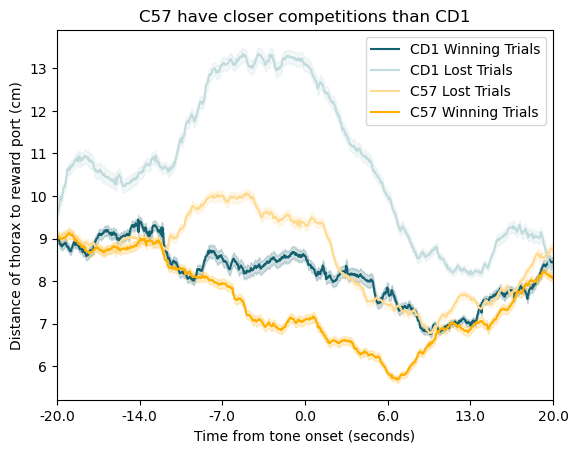

In [94]:
# Add shading for the standard error
plt.plot(cd1_winning_mean_distance, color="#15616F", label="CD1 Winning Trials")
plt.fill_between(range(len(cd1_winning_mean_distance)), cd1_winning_mean_distance - cd1_winning_sem_distance, cd1_winning_mean_distance + cd1_winning_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(cd1_losing_mean_distance, color="#C2DBDC", label="CD1 Lost Trials")
plt.fill_between(range(len(cd1_losing_mean_distance)), cd1_losing_mean_distance - cd1_losing_sem_distance, cd1_losing_mean_distance + cd1_losing_sem_distance, color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_losing_mean_distance, color="#FFDB91", label="C57 Lost Trials")
plt.fill_between(range(len(c57_losing_mean_distance)), c57_losing_mean_distance - c57_losing_sem_distance, c57_losing_mean_distance + c57_losing_sem_distance, color="#FFDB91", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_winning_mean_distance, color="#FFAF00", label="C57 Winning Trials")
plt.fill_between(range(len(c57_winning_mean_distance)), c57_winning_mean_distance - c57_winning_sem_distance, c57_winning_mean_distance + c57_winning_sem_distance, color="#ffaf00", alpha=0.2)


plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)

plt.title("C57 have closer competitions than CD1")

plt.legend()

# Separating by overall winner and loser

In [95]:
raise ValueError()

ValueError: 

In [96]:
no_tie_distance_and_scoring_df = distance_and_scoring_df[~distance_and_scoring_df["rc_is_win_to_win_and_loss_ratio_tie"]]

In [97]:
no_tie_distance_and_scoring_df["is_winner"] = no_tie_distance_and_scoring_df["subj"] == no_tie_distance_and_scoring_df["rc_averaged_winner"]

In [100]:
c57_winner_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "C57") & (no_tie_distance_and_scoring_df["is_winner"])]
c57_loser_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "C57") & ~(no_tie_distance_and_scoring_df["is_winner"])]

cd1_winner_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "CD1") & (no_tie_distance_and_scoring_df["is_winner"])]
cd1_loser_distance_and_scoring_df = no_tie_distance_and_scoring_df[(no_tie_distance_and_scoring_df["Strain"] == "CD1") & ~(no_tie_distance_and_scoring_df["is_winner"])]

In [103]:
c57_winner_mean_distance = np.mean(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
c57_winner_sem_distance = np.std(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(c57_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  
c57_loser_mean_distance = np.mean(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
c57_loser_sem_distance = np.std(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(c57_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  

cd1_winner_mean_distance = np.mean(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_winner_sem_distance = np.std(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(cd1_winner_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  
cd1_loser_mean_distance = np.mean(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"], axis=0)
cd1_loser_sem_distance = np.std(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].to_list(), axis=0) / np.sqrt(cd1_loser_distance_and_scoring_df["thorax_to_reward_port_tone_trial_average_subj"].iloc[0].shape[0])  


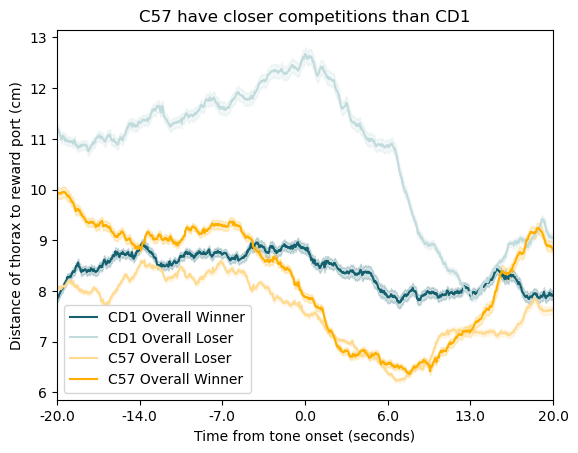

In [105]:
# Add shading for the standard error
plt.plot(cd1_winner_mean_distance, color="#15616F", label="CD1 Overall Winner")
plt.fill_between(range(len(cd1_winner_mean_distance)), cd1_winner_mean_distance - cd1_winner_sem_distance, cd1_winner_mean_distance + cd1_winner_sem_distance, color="#15616f", alpha=0.2)

# Add shading for the standard error
plt.plot(cd1_loser_mean_distance, color="#C2DBDC", label="CD1 Overall Loser")
plt.fill_between(range(len(cd1_loser_mean_distance)), cd1_loser_mean_distance - cd1_loser_sem_distance, cd1_loser_mean_distance + cd1_loser_sem_distance, color="#C2DBDC", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_loser_mean_distance, color="#FFDB91", label="C57 Overall Loser")
plt.fill_between(range(len(c57_loser_mean_distance)), c57_loser_mean_distance - c57_loser_sem_distance, c57_loser_mean_distance + c57_loser_sem_distance, color="#FFDB91", alpha=0.2)

# Add shading for the standard error
plt.plot(c57_winner_mean_distance, color="#FFAF00", label="C57 Overall Winner")
plt.fill_between(range(len(c57_winner_mean_distance)), c57_winner_mean_distance - c57_winner_sem_distance, c57_winner_mean_distance + c57_winner_sem_distance, color="#ffaf00", alpha=0.2)


plt.ylabel("Distance of thorax to reward port (cm)")
plt.xlabel("Time from tone onset (seconds)")

xticks = plt.xticks()[0]  # Get current x-axis ticks
plt.xticks(xticks, xticks // 30 - 20)  # Set new x-axis ticks
plt.xlim(0, 1200)

plt.title("C57 have closer competitions than CD1")

plt.legend()

In [ ]:
raise ValueError()

In [ ]:
distance_and_scoring_df["subj"].unique()

In [ ]:
reward_comp_scoring_df["rc_winner"].iloc[0]

In [ ]:
rc_outcome_df = pd.read_excel("./data/iwata_pilot_3_reward_competition.xlsx")

In [ ]:
rc_outcome_df["subj_1"] = rc_outcome_df["Match"].apply(lambda x: sorted([num.strip() for num in x.split("vs")])[0])
rc_outcome_df["subj_2"] = rc_outcome_df["Match"].apply(lambda x: sorted([num.strip() for num in x.split("vs")])[1])
rc_outcome_df["all_subj"] = rc_outcome_df.apply(lambda x: tuple(sorted([x["subj_1"], x["subj_2"]])) , axis=1)

In [ ]:
rc_outcome_df

In [ ]:
rc_outcome_df["subj_1"].unique()

In [ ]:
rc_outcome_df["subj_1"].unique()

In [ ]:
raise ValueError()

In [ ]:
np.mean(tone_start_df["thorax_to_reward_port_tone_slices_subj_1"].iloc[0], axis=0)


In [ ]:
plt.plot(cd1_mean_distance)

In [ ]:
for num in tone_start_df["thorax_to_reward_port_tone_slices_subj_1"]:
    print(num.shape)

In [ ]:
 np.vstack([arr[start:end] for start, end in ranges])

In [ ]:
((23)**2 + (29.5)**2)**0.5

In [ ]:
tone_start_df["thorax_to_reward_port_distance_subj_1"].iloc[0].shape

In [ ]:
for num in range(2):
#     print(num)

In [ ]:
tone_start_df["pose_estimation_subj_2_thorax_coordinates"].iloc[0]

In [ ]:
tone_start_df["pose_estimation_subj_1_thorax_coordinates"] = 

In [ ]:
tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]

In [ ]:
(tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]).shape

In [ ]:
np.dstack((tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,0] * tone_start_df["width_ratio"].iloc[0], tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,1] * tone_start_df["height_ratio"].iloc[0]))

In [ ]:
tone_start_df["pose_estimation_subj_1_coordinates"].iloc[0][:,:,:]

3000: the number of frames;

13: the number of nodes in the skeleton (we’ve also loaded and displayed the node_names dataset with the names of these 13 nodes);

2: for the x and y coordinates;

2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn’t work as well).

In [ ]:
tone_start_df["pose_estimation_subj_1"] = 
tone_start_df["pose_estimation_subj_1"] = 

In [ ]:
node_names

In [ ]:
tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [ ]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["pose_estimation_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

# Calculate Distance from Thorax to Reward Port

In [ ]:
for index, node in enumerate(corner_node_names):
    tone_start_df["{}_coordinates".format(node)] = tone_start_df["corner_file"].apply(lambda x: get_sleap_coordinates(x)[0][0,index,:,0])

In [ ]:
raise ValueError()

- Calculating Horizontal and Vertical Distances

In [ ]:
tone_start_df["horizontal_length"] = tone_start_df.apply(lambda row: row["box_bottom_left_coordinates"][])

In [ ]:
filename = all_corner_h5[0]

In [ ]:

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

In [ ]:
locations[0,1,0,0]

In [ ]:
locations[0,1,1,0]

In [ ]:
for index, row in tone_start_df.iterrows():
    print(row["corner_file"])
    